## 收集数据

In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
# 收集推特图像的预测数据
url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/数据清洗/WeRateDogs项目/image-predictions.tsv"
response = requests.get(url)
with open("image-predictions.tsv", "w") as fb:
    fb.write(response.text)

In [3]:
# 三个文件收集完毕，现在将数据读如 DataFrame
df_arc = pd.read_csv("twitter-archive-enhanced.csv")
df_img = pd.read_csv("image-predictions.tsv", sep="\t")

# 导师的意见
# 1. 使用 Pandas 的 `read_json` 函数 https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
# 2. 只获取 `id`, `retweet_count` 和 `favorite_count` 三列
df_api = pd.read_json('tweet_json.txt', lines=True)[['id', 'retweet_count', 'favorite_count']]

## 评估数据

In [4]:
# `rating_denominator` 有些是 10，有些不是 10
df_arc.query("rating_denominator != 10").head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [5]:
# `rating_numerator` 缺少小数点精度
df_arc.query("tweet_id==832215909146226688").head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None


In [6]:
# `name=None` 未识别成 NaN
# `name` 大小写不统一
df_arc['name'].value_counts()[:5]

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Name: name, dtype: int64

In [7]:
# `tweet_id` 类型是 int，应该是 str
df_arc.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [8]:
# 有些狗狗存在两个stage
df_arc.query('doggo!="None" and floofer!="None"')[['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']]

,tweet_id,doggo,floofer,pupper,puppo
200,854010172552949760,doggo,floofer,None,None


In [9]:
# 狗狗分类 `None` 未识别成 NaN
df_arc['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [10]:
# 数据里包含转发的 Tweet
df_arc['retweeted_status_id'].notnull().sum()

181

#### 质量
1. `twitter-archive-enhanced.csv`: `rating_numerator` 缺少小数点精度
2. `twitter-archive-enhanced.csv`: `rating_denominator` 有些是 10，有些不是 10
3. `twitter-archive-enhanced.csv`: `name` 大小写不统一
4. `twitter-archive-enhanced.csv`: `name=None` 未识别成 NaN
5. `twitter-archive-enhanced.csv`: `tweet_id` 类型是 int，应该是 str
6. `twitter-archive-enhanced.csv`: 有些狗狗存在两个stage（如tweet_id=854010172552949760）
7. `twitter-archive-enhanced.csv`: 狗狗分类 `None` 未识别成 NaN
8. `twitter-archive-enhanced.csv`: 清理转发的 Tweet

#### 清洁度
1. 狗狗的 `Stage` 用了四列来表示（doggo, floofer, pupper, puppo）
2. 三个数据集都是以 `tweet_id` 为观察单位，需要合并成一个表

## 清理数据

In [11]:
cleaned_df_arc = df_arc.copy()
cleaned_df_api = df_api.copy()
cleaned_df_img = df_img.copy()

#### 质量

##### 1. `rating_numerator` 缺少小数点精度

##### 定义
重新提取狗狗评分的分子 `rating_numerator`

##### 代码

In [12]:
# 关于评分导师意见
# 1. 比如评分 99/90 是 9 只狗狗的 “总评分”，也是「正确」的评分，修改后的评分通过是 9/10（如tweet_id="713900603437621249"）
# 2. 分子中存在小数情况
# 3. 推文中存在两个分数形式的数字，而最后一个评分才是正确的

# 提取评分
rating = cleaned_df_arc['text'].str.findall('((?:\d+\.)?\d+/[1-9]+[0]+)').apply(lambda x: x[-1] if len(x) > 0 else x)
rating = rating.str.split('/',n=1, expand=True)
rating.columns = ['rating_numerator', 'rating_denominator'] # 列名

cleaned_df_arc['rating_numerator'] = rating['rating_numerator'].astype(float)
cleaned_df_arc['rating_denominator'] = rating['rating_denominator'].astype(float)

# 统一将评分修改为分母为 10 
# 新的分子等于：原来的分子 / 原来的分母 * 10
cleaned_df_arc['rating_numerator']  = cleaned_df_arc['rating_numerator'] / cleaned_df_arc['rating_denominator'] *10
# 将分子修改完毕后，可以直接为分母赋值为 10
cleaned_df_arc['rating_denominator'] = 10

##### 测试

In [13]:
cleaned_df_arc['rating_numerator'].value_counts()

12.00      561
11.00      472
10.00      455
13.00      355
9.00       157
8.00       104
14.00       56
7.00        56
5.00        34
6.00        33
3.00        19
4.00        16
2.00        11
1.00         9
0.00         2
15.00        2
420.00       2
9.75         2
11.26        1
9.50         1
11.27        1
666.00       1
13.50        1
1776.00      1
182.00       1
Name: rating_numerator, dtype: int64

##### 2. `rating_denominator` 有些是 10，有些不是 10

##### 定义
将分母统一修改为 10 

##### 代码

In [14]:
cleaned_df_arc['rating_denominator'] = 10

##### 测试

In [15]:
cleaned_df_arc['rating_denominator'].value_counts()

10    2356
Name: rating_denominator, dtype: int64

#### 3. `name` 大小写不统一

##### 定义
将 `name` 为小写的狗狗名字改成 NaN

##### 代码

In [16]:
cleaned_df_arc.loc[cleaned_df_arc.name.str.islower(), "name"] = 'None'

##### 测试

In [17]:
cleaned_df_arc[cleaned_df_arc.name.str.islower()].name.value_counts()

Series([], Name: name, dtype: int64)

#### 4. `name=None` 没识别成 NaN

##### 定义
将名字是 `None` 狗狗名字标志成 NaN

##### 代码

In [18]:
cleaned_df_arc.loc[cleaned_df_arc.name == "None", "name"] = np.nan

##### 测试

In [19]:
len(cleaned_df_arc.query("name=='None'"))

0

#### 5. `tweet_id` 类型是 int，应该是 str

##### 定义
将 `tweet_id` 的数据类型转成 `str`

##### 代码

In [20]:
cleaned_df_arc["tweet_id"] = cleaned_df_arc.astype("str")

##### 测试

In [21]:
cleaned_df_arc.dtypes

tweet_id                       object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator              float64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

##### 6. `twitter-archive-enhanced.csv`: 有些狗狗存在两个stage（如tweet_id=854010172552949760）

##### 定义
将包含两个 `stage` 的狗狗，默认值保留第一个 `stage`

##### 代码

In [22]:
cleaned_df_arc.loc[cleaned_df_arc.query("doggo!='None' and floofer!='None'").index, 'floofer'] = 'None'
cleaned_df_arc.loc[cleaned_df_arc.query("doggo!='None' and pupper!='None'").index, 'pupper'] = 'None'
cleaned_df_arc.loc[cleaned_df_arc.query("doggo!='None' and puppo!='None'").index, 'puppo'] = 'None'

##### 测试

In [23]:
cleaned_df_arc.query("doggo!='None' and floofer!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [24]:
cleaned_df_arc.query("doggo!='None' and pupper!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [25]:
cleaned_df_arc.query("doggo!='None' and puppo!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [26]:
cleaned_df_arc.query("floofer!='None' and pupper!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [27]:
cleaned_df_arc.query("floofer!='None' and puppo!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [28]:
cleaned_df_arc.query("pupper!='None' and puppo!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


##### 7. `twitter-archive-enhanced.csv`: 狗狗分类 `None` 未识别成 NaN

##### 定义
将狗狗分类是 `None` 的改成 NaN

##### 代码

In [29]:
cleaned_df_arc.loc[cleaned_df_arc.query("doggo=='None'").index, "doggo"] = np.nan
cleaned_df_arc.loc[cleaned_df_arc.query("floofer=='None'").index, "floofer"] = np.nan
cleaned_df_arc.loc[cleaned_df_arc.query("pupper=='None'").index, "pupper"] = np.nan
cleaned_df_arc.loc[cleaned_df_arc.query("puppo=='None'").index, "puppo"] = np.nan

##### 测试

In [30]:
len(cleaned_df_arc.query("doggo=='None'"))

0

In [31]:
len(cleaned_df_arc.query("floofer=='None'"))

0

In [32]:
len(cleaned_df_arc.query("pupper=='None'"))

0

In [33]:
len(cleaned_df_arc.query("puppo=='None'"))

0

##### 8. `twitter-archive-enhanced.csv`: 清理转发的 Tweet

##### 定义
删除转发的 Tweet

##### 代码

In [34]:
cleaned_df_arc = cleaned_df_arc.query('retweeted_status_id=="Nan"')

##### 测试

In [35]:
cleaned_df_arc['retweeted_status_id'].notnull().sum()

0

#### 清洁度

##### 1. 狗狗的 `Stage` 用了四列来表示（doggo, floofer, pupper, puppo）

##### 定义
将狗狗的 `Stage` 合并成一列

##### 代码

In [36]:
stages = []
for index, row in cleaned_df_arc.iterrows():
    cat = np.nan
    for stage in ['doggo', 'floofer', 'pupper', 'puppo']:
        if row[stage] == stage:
            cat = stage
            break
    stages.append(cat)
cleaned_df_arc['stage'] = stages
cleaned_df_arc['stage'] = cleaned_df_arc['stage'].astype('category')

In [37]:
cleaned_df_arc["stage"].value_counts()

pupper     224
doggo       87
puppo       24
floofer      9
Name: stage, dtype: int64

In [38]:
cleaned_df_arc.query("tweet_id=='886366144734445568'")
# cleaned_df_arc.head()
# cleaned_df_arc.dtypes

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12.0,10,Roscoe,NaN,NaN,pupper,NaN,pupper


##### 2. 三个数据集都是以 `tweet_id` 为观察单位，需要合并成一个表

In [39]:
# 合并成一个 DataFrame
# 这里对数据集进行 `merge` 时选择 `inner` 方式，这样就可以删掉没有图片的推文
cleaned_df_arc['tweet_id'] = cleaned_df_arc['tweet_id'].astype('int64')
cleaned_df_api.rename(columns={'id': 'tweet_id'}, inplace=True)
merged_df = cleaned_df_arc[['tweet_id', 'timestamp', 'text', 'rating_numerator', 'rating_denominator', 'name', 'stage']].merge(
    cleaned_df_api[['tweet_id', 'favorite_count', 'retweet_count']], on = 'tweet_id'
).merge(
    cleaned_df_img[['tweet_id', 'p1', 'p1_conf', 'p1_dog']], on = 'tweet_id'
)

In [40]:
# 检查要点
# 1. 不包含转发的推文
# 2. 不包含没有图片的推文
print(merged_df['text'].str.contains('RT @').sum())
print(merged_df['p1'].isnull().sum())

0
0


In [41]:
merged_df.query('tweet_id=="713900603437621249"')

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,p1,p1_conf,p1_dog
946,713900603437621249,2016-03-27 01:29:02 +0000,Happy Saturday here's 9 puppers on a bench. 99...,11.0,10,NaN,NaN,3049,827,golden_retriever,0.371816,True


##### 3. 将数据集设置成时序索引

In [42]:
merged_df['datetime'] = pd.to_datetime(merged_df['timestamp'], utc=True)
merged_df = merged_df.set_index('datetime')
merged_df.drop(['timestamp'], axis=1, inplace=True)
merged_df.index

DatetimeIndex(['2017-08-01 16:23:56+00:00', '2017-08-01 00:17:27+00:00',
               '2017-07-31 00:18:03+00:00', '2017-07-30 15:58:51+00:00',
               '2017-07-29 16:00:24+00:00', '2017-07-29 00:08:17+00:00',
               '2017-07-28 16:27:12+00:00', '2017-07-28 00:22:40+00:00',
               '2017-07-27 16:25:51+00:00', '2017-07-26 15:59:51+00:00',
               ...
               '2015-11-16 01:01:59+00:00', '2015-11-16 00:55:59+00:00',
               '2015-11-16 00:49:46+00:00', '2015-11-16 00:35:11+00:00',
               '2015-11-16 00:30:50+00:00', '2015-11-16 00:24:50+00:00',
               '2015-11-16 00:04:52+00:00', '2015-11-15 23:21:54+00:00',
               '2015-11-15 23:05:30+00:00', '2015-11-15 22:32:08+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=1994, freq=None)

In [43]:
# pd.to_datetime(cleaned_df_arc['timestamp'])
# type(cleaned_df_arc['timestamp'][0])
# pd.to_datetime(cleaned_df_arc['timestamp'][1])
# pd.to_datetime(cleaned_df_arc.timestamp)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1994 entries, 2017-08-01 16:23:56+00:00 to 2015-11-15 22:32:08+00:00
Data columns (total 11 columns):
tweet_id              1994 non-null int64
text                  1994 non-null object
rating_numerator      1993 non-null float64
rating_denominator    1994 non-null int64
name                  1350 non-null object
stage                 306 non-null category
favorite_count        1994 non-null int64
retweet_count         1994 non-null int64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null bool
dtypes: bool(1), category(1), float64(2), int64(4), object(3)
memory usage: 159.9+ KB


In [44]:
# 保存到 CSV 文件
merged_df.to_csv('cleaned_tweets.csv')

In [45]:
df = pd.read_csv('cleaned_tweets.csv', index_col = 'datetime')
df.head(5)

,tweet_id,text,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count,p1,p1_conf,p1_dog
datetime,,,,,,,,,,,
2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,39492,8842,orange,0.097049,False
2017-08-01 00:17:27+00:00,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,33786,6480,Chihuahua,0.323581,True
2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,25445,4301,Chihuahua,0.716012,True
2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,42863,8925,paper_towel,0.170278,False
2017-07-29 16:00:24+00:00,891327558926688256,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,41016,9721,basset,0.555712,True


## 数据探索分析

In [46]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

df = pd.read_csv('cleaned_tweets.csv', index_col = 'datetime', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1994 entries, 2017-08-01 16:23:56+00:00 to 2015-11-15 22:32:08+00:00
Data columns (total 11 columns):
tweet_id              1994 non-null int64
text                  1994 non-null object
rating_numerator      1993 non-null float64
rating_denominator    1994 non-null int64
name                  1350 non-null object
stage                 306 non-null object
favorite_count        1994 non-null int64
retweet_count         1994 non-null int64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 173.3+ KB


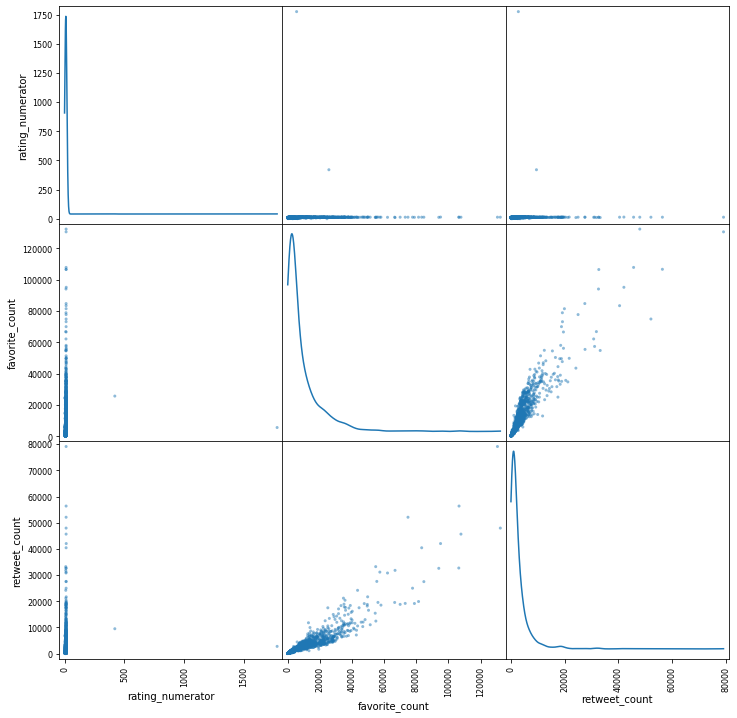

In [47]:
# 导师意见
# `rating_denominator` 统一为 10，对于这样的常数，没有必要验证与其他变量的线性相关
lis = ['rating_numerator', 'favorite_count', 'retweet_count']
scatter_matrix(df[lis], figsize=(12, 12), diagonal='kde');

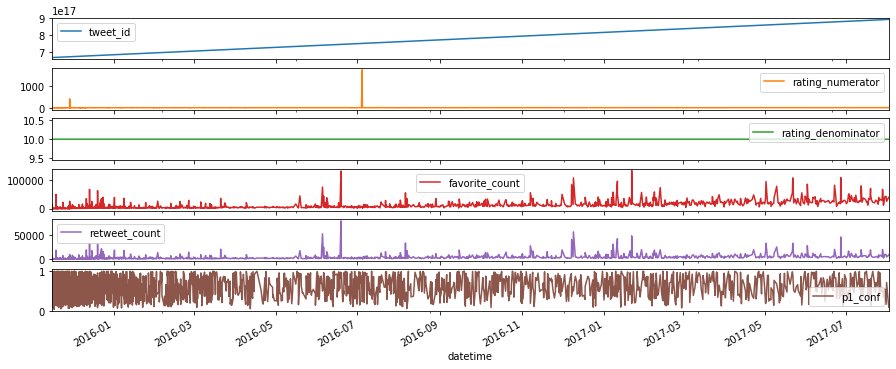

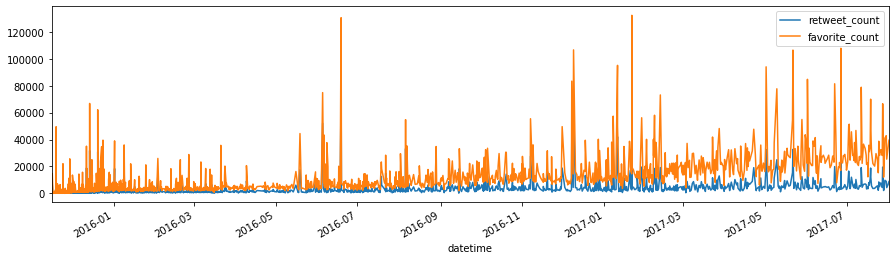

In [48]:
df.plot(subplots=True, figsize=(15, 6))
df.plot(y=['retweet_count', 'favorite_count'], figsize=(15,4))

/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


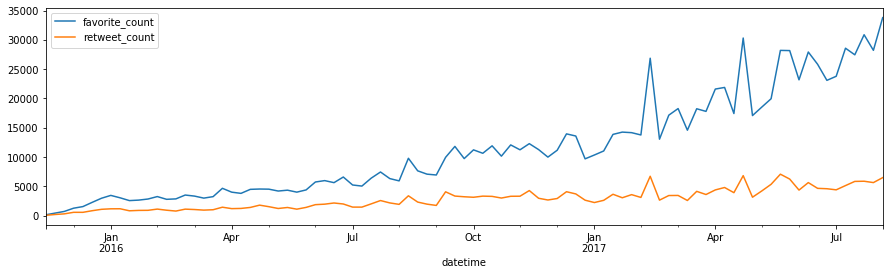

In [49]:
df[['favorite_count', 'retweet_count']].resample("1w").median().plot(figsize=(15,4))

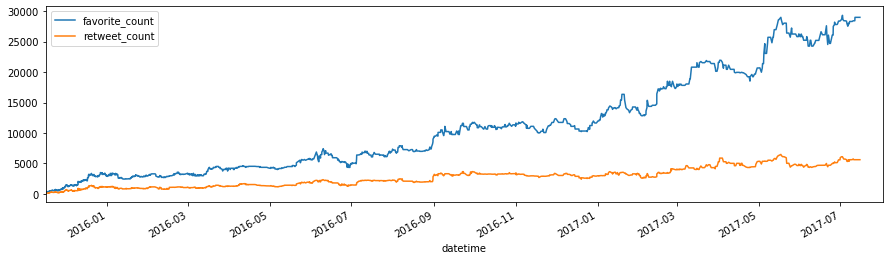

In [50]:
df[['favorite_count', 'retweet_count']].rolling(30).median().plot(figsize=(15,4))

## 得出结论

### `favorite_count` 和 `retweet_count` 的时序分析

Text(0, 0.5, 'Counts')

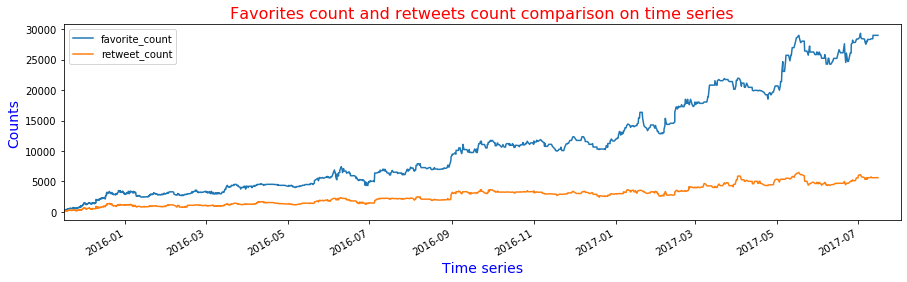

In [51]:
df[['favorite_count', 'retweet_count']].rolling(30).median().plot(figsize=(15,4))

plt.title('Favorites count and retweets count comparison on time series', color='r', fontsize=16)
plt.xlabel('Time series', color='b', fontsize=14)
plt.ylabel('Counts', color='b', fontsize=14)

- 2016年7月之前的喜欢数大概是转发数的两倍
- 2016年7月后喜欢数出现了爆发式增长，同时转发数量持续缓慢增长
- twitter 的增长很快
- 人们更愿意用点赞的方式来进行 social，而非成本更高的转发

### `favorite_count` 和 `retweet_count` 相关性分析

/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


Text(0, 0.5, 'Retweets Count')

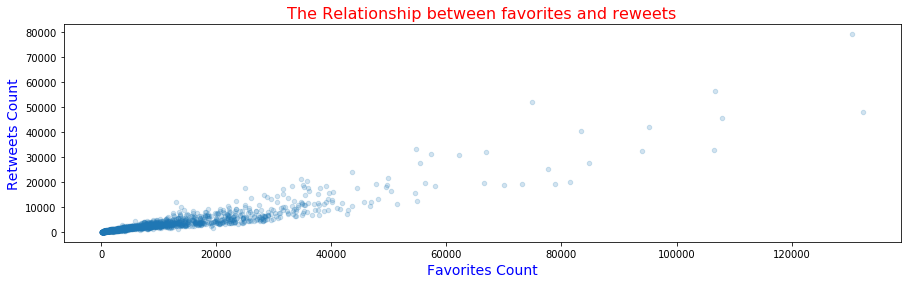

In [52]:
df.query('favorite_count > 0').plot.scatter(x='favorite_count', y='retweet_count', alpha=0.2, figsize=(15,4))

plt.title('The Relationship between favorites and reweets', color='r', fontsize=16)
plt.xlabel('Favorites Count', color='b', fontsize=14)
plt.ylabel('Retweets Count', color='b', fontsize=14)

- 可以看出喜欢数和转发数直接存在着相关性